In [382]:
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares
import pandas as pd
from scipy import constants

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [383]:
parent = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IR_KIDS_CHAR\2o raff\RES_DATA'

In [384]:
data = pd.read_csv(parent+r'\RES0.txt', sep='\t')

In [385]:
def resonance_model(f, pars):
    x = (f-pars[3])/pars[3]
    return 1-(pars[0]/pars[1])*(np.exp(1j*pars[2])/(1+1j*2*x*pars[0]))

polyorder = 2

def model(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return pol*np.abs(res)

def phase(x,*pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.unwrap(np.angle(1j*res.imag+res.real+pol))

In [386]:
F = data['F']
I = data['I']
Q = data['Q']

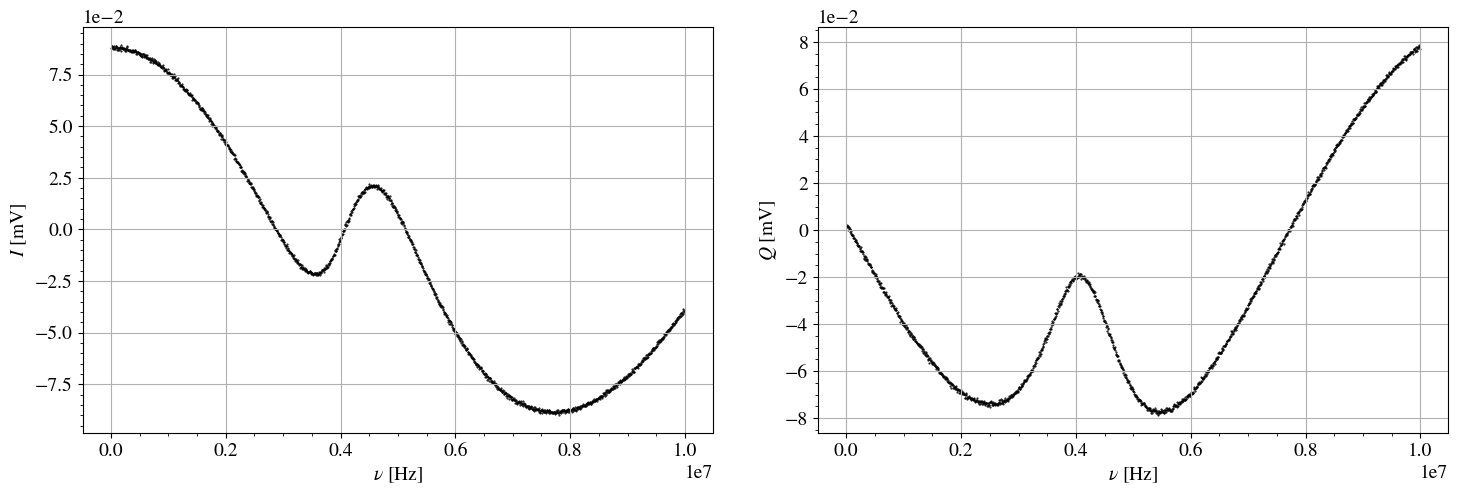

In [389]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,I,s=1,marker='.',color='black')
axs[0].set_xlabel(r'$\nu$ [Hz]')
axs[0].set_ylabel(r'$I$ [mV]')
axs[1].scatter(F,Q,s=1,marker='.',color='black')
axs[1].set_xlabel(r'$\nu$ [Hz]')
axs[1].set_ylabel(r'$Q$ [mV]')
fig.tight_layout()
# Optionally add minor ticks and scientific notation
axs[1].minorticks_on()
axs[1].grid()
axs[1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0].minorticks_on()
axs[0].grid()
axs[0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))

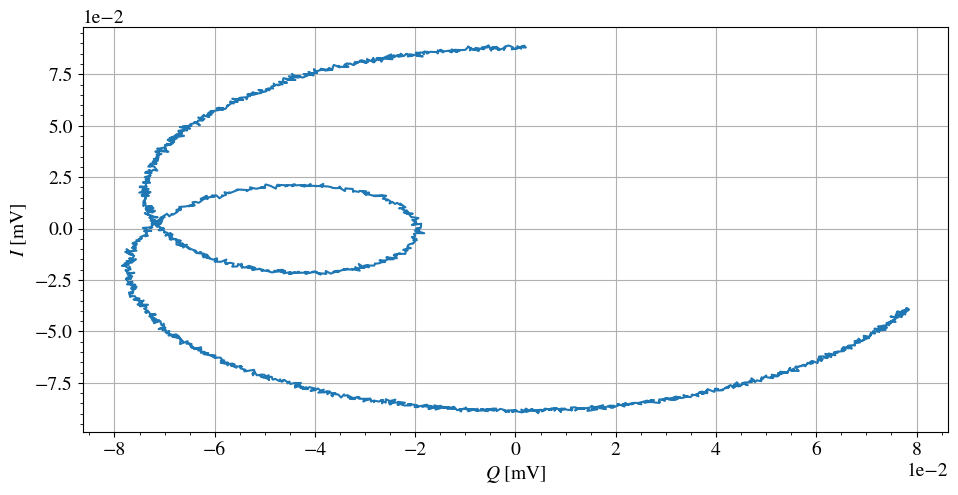

In [395]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
axs.plot(Q,I)
#axs.plot(Q,I,s=1,marker='.',color='black')
axs.set_xlabel(r'$Q$ [mV]')
axs.set_ylabel(r'$I$ [mV]')
fig.tight_layout()
axs.grid()
axs.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs.minorticks_on()

In [398]:
C = np.array(Q)+1j*np.array(I)
A = np.abs(C)
F = np.array(F)
F = F- F[A.argmin()] +5.3465*1e9
P = np.unwrap(np.angle(C))

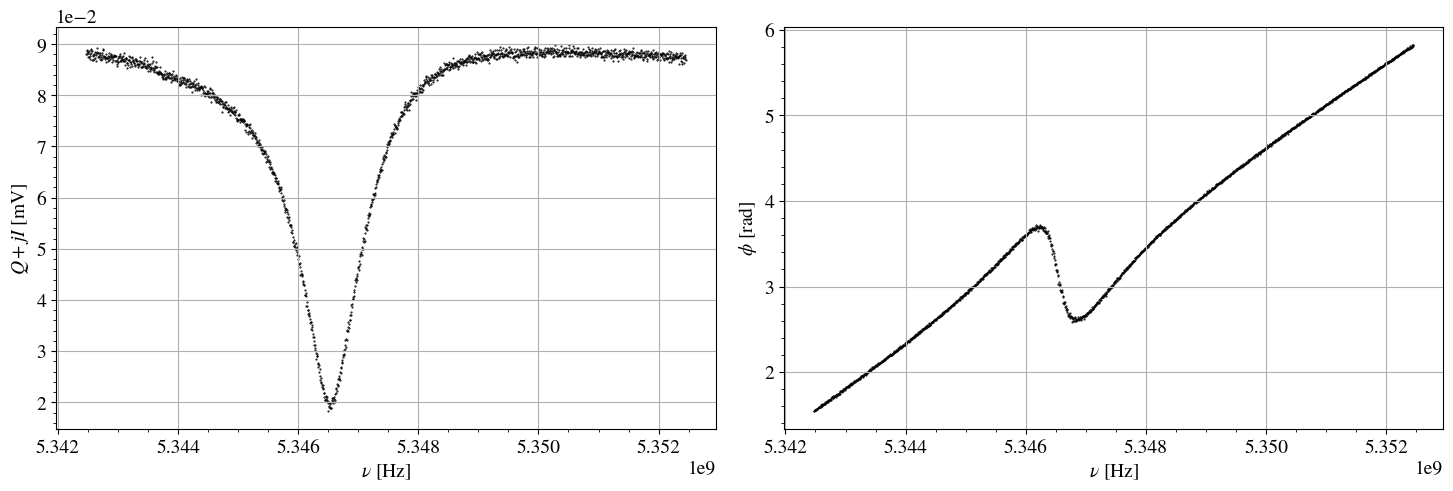

In [399]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black')
axs[0].set_xlabel(r'$\nu$ [Hz]')
axs[0].set_ylabel(r'$Q+jI$ [mV]')
axs[1].scatter(F,P,s=1,marker='.',color='black')
axs[1].set_xlabel(r'$\nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
fig.tight_layout()
# Optionally add minor ticks and scientific notation
axs[1].minorticks_on()
axs[1].grid()
axs[1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0].minorticks_on()
axs[0].grid()
axs[0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))

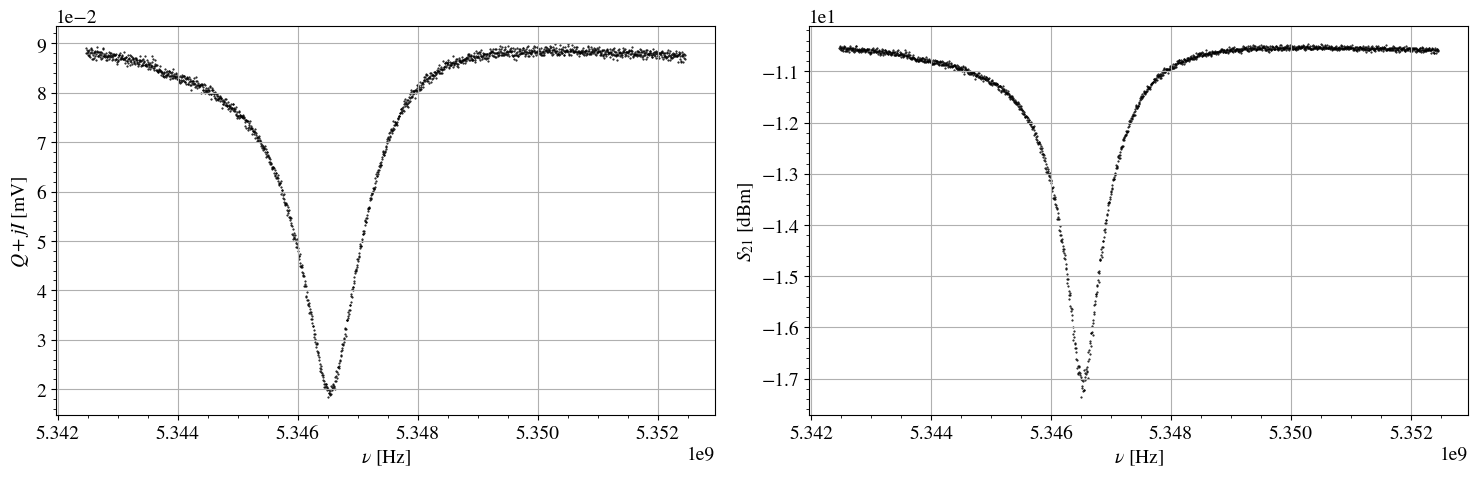

In [403]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black')
axs[0].set_xlabel(r'$\nu$ [Hz]')
axs[0].set_ylabel(r'$Q+jI$ [mV]')
axs[1].scatter(F,20*np.log10(np.sqrt(A)),marker='.',color='black',s=1)
axs[1].set_xlabel(r'$\nu$ [Hz]')
axs[1].set_ylabel(r'$S_{21}$ [dBm]')
axs[0].minorticks_on()
axs[0].grid()
axs[0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))

axs[1].minorticks_on()
axs[1].grid()
axs[1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))

fig.tight_layout()

In [365]:
def calculate_fwhm(x, y):
    """
    Calculate the Full Width at Half Maximum (FWHM) of a resonance curve without interpolation.

    Parameters:
    x (numpy.ndarray): The x data points (e.g., frequency or energy).
    y (numpy.ndarray): The y data points (e.g., intensity or amplitude).

    Returns:
    fwhm (float): The full width at half maximum of the resonance.
    roots (list): The positions of the two half-maximum points.
    """

    # Identify the indices where the y data crosses the half maximum
    indices_above_half_max = np.where(y >= y.max() / 2.0)[0]
    print(indices_above_half_max)
    
    if len(indices_above_half_max) < 2:
        raise ValueError("Not enough data points crossing the half maximum to calculate FWHM.")

    # The FWHM corresponds to the difference between the first and last index crossing the half maximum
    left_idx = indices_above_half_max[0]
    right_idx = indices_above_half_max[-1]
    print(left_idx)
    print(right_idx)

    # Estimate the roots using the x values at these indices
    root1 = x[left_idx]
    root2 = x[right_idx]
    
    # FWHM is the difference between the two roots
    fwhm = np.abs(root2 - root1)

    return fwhm, [root1, root2]

In [366]:
t1 = np.where(A[np.argmin(A)-200:np.argmin(A)+200]<A[np.argmin(A)-200:np.argmin(A)+200].max()/2)[0][-1]
t2 = np.where(A[np.argmin(A)-200:np.argmin(A)+200]<A[np.argmin(A)-200:np.argmin(A)+200].max()/2)[0][0]
FWHM = abs((F[np.argmin(A)-200:np.argmin(A)+200]-F[A.argmin()])[t1]-(F[np.argmin(A)-200:np.argmin(A)+200]-F[A.argmin()])[t2])

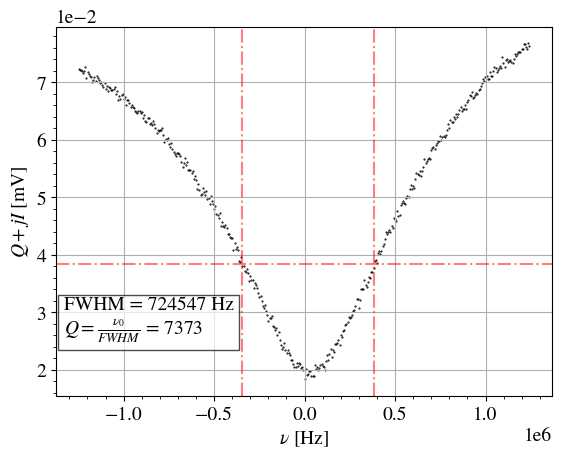

In [367]:
fig, axs = plt.subplots(1,1)
axs.axhline(A[np.argmin(A)-200:np.argmin(A)+200].max()/2,0,1,linestyle='-.',color='red',alpha=0.5)
axs.axvline((F[np.argmin(A)-200:np.argmin(A)+200]-F[A.argmin()])[t1],0,1,linestyle='-.',color='red',alpha=0.5)
axs.axvline((F[np.argmin(A)-200:np.argmin(A)+200]-F[A.argmin()])[t2],0,1,linestyle='-.',color='red',alpha=0.5)
axs.scatter(F[np.argmin(A)-200:np.argmin(A)+200]-F[A.argmin()],A[np.argmin(A)-200:np.argmin(A)+200],s=1,marker='.',color='black')
axs.set_xlabel(r'$\nu$ [Hz]')
axs.set_ylabel(r'$Q+jI$ [mV]')
axs.minorticks_on()
axs.grid()
axs.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
text_str = f'FWHM = {FWHM:.0f} Hz\n' + r'$Q = \frac{\nu_{0}}{FWHM}$' + f' = {5.342*1e9/FWHM:.0f}'

# Place the combined text with a bounding box
axs.text(-1.33*1e6, 2.6*1e-2, text_str,
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.show()

In [368]:
A = 20*np.log10(np.sqrt(A))
#F = (F - F[np.argmin(A)])/F[np.argmin(A)]
a = np.polyfit(F[:100],P[:100],1)
P = P - np.polyval(a,F)
len_fit = int(np.floor(len(A)/10))
pol_amp = np.polyfit(F[:len_fit], A[:len_fit], 2)
A_rms = np.sqrt(np.mean((np.polyval(pol_amp, F[:len_fit])-A[:len_fit])**2))   

In [369]:
pol_ph = np.polyfit(F[:len_fit], P[:len_fit], 2)
P_rms = np.sqrt(np.mean((np.polyval(pol_ph, F[:len_fit])-P[:len_fit])**2))

In [372]:
p0 = [1e-20,1e-15,-11,7e3,9e3,3.2,5.3465*1e9]

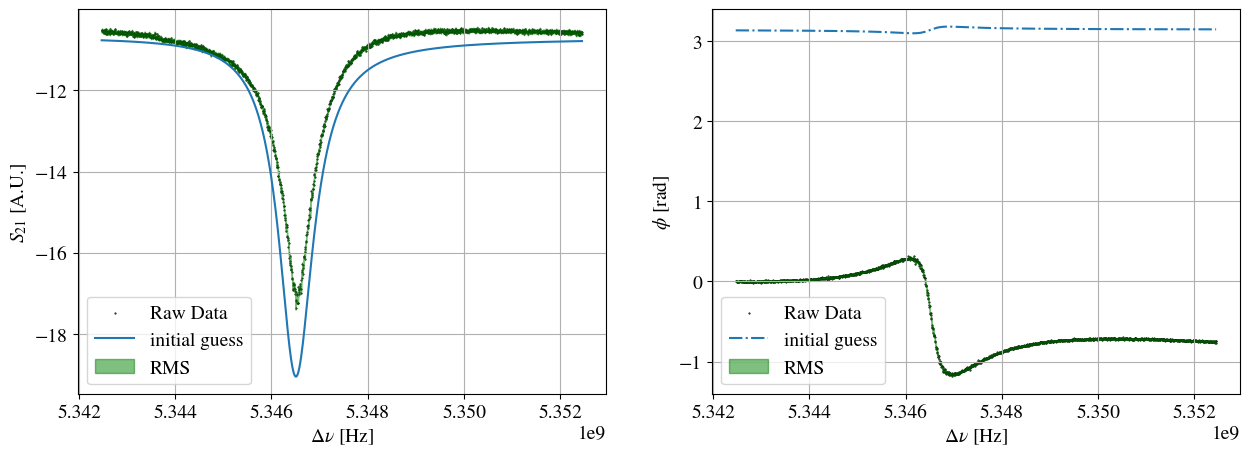

In [373]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F,model(F,*p0), label='initial guess')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].plot(F,phase(F,*p0),linestyle='-.', label='initial guess')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [374]:
lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
m= minuit.Minuit(lsq, *p0)
m.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.076e+04 (χ²/ndof = 6.8)  │              Nfcn = 291              │
│ EDM = 4.75e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │-0.826e-18 │ 0.033e-18 │            │            │         │         │       │
│ 1 │ x1   │ 12.17e-12 │ 0.12e-12  │            │            │         │         │       │
│ 2 │ x2   │    13     │     1     │            │            │         │         │       │
│ 3 │ x3   │  6.797e3  │  0.008e3  │            │            │         │         │       │
│ 4 │ x4   │ 11.260e3  │  0.011e3  │            │            │         │         │       │
│ 5 │ x5   │  3.0302   │  0.0011   │            │            │         │         │       │
│ 6 │ x6   │5.3465537e9│0.0000004e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                            x0                            x1                            x2                            x3                            x4                            x5                            x6 │
├────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                      1.11e-39                  -50.2692e-36   -31.8740059687505983277e-21    67.3143381670695362118e-21   134.2393404627125619299e-21       24.3039096238299912e-24 -6.5958035644148926834873e-18 │
│ x1 │                  -50.2692e-36                      1.35e-26            1.425274438179e-15         -224.267056493827e-15         -451.741151765973e-15               7.575308710e-18        -2.442759893518388e-12 │
│ x2 │   -31.8740059687505983277e-21            1.425274438179e-15                         0.912                          -1.9                          -3.8                     -695.0e-6                         188.6 │
│ x3 │    67.3143381670695362118e-21         -224.267056493827e-15                          -1.9                          59.2                            70                     1.1509e-3                          -320 │
│ x4 │   134.2393404627125619299e-21         -451.741151765973e-15                          -3.8                            70                           121                     2.1489e-3                       -0.55e3 │
│ x5 │       24.3039096238299912e-24               7.575308710e-18                     -695.0e-6                     1.1509e-3                     2.1489e-3                      1.16e-06                  -352.0289e-3 │
│ x6 │ -6.5958035644148926834873e-18        -2.442759893518388e-12                         188.6                    

In [375]:
lsqp = LeastSquares(F,P,P_rms*np.ones(len(P)),phase)
mp = minuit.Minuit(lsqp, *p0)
mp.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.868e+06 (χ²/ndof = 1173.1)│             Nfcn = 10001             │
│ EDM = 0.0219 (Goal: 0.0002)      │            time = 4.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 16.2e-18  │  0.6e-18  │            │            │         │         │       │
│ 1 │ x1   │  116e-9   │   4e-9    │            │            │         │         │       │
│ 2 │ x2   │    772    │    28     │            │            │         │         │       │
│ 3 │ x3   │ 2.6400e3  │ 0.0031e3  │            │            │         │         │       │
│ 4 │ x4   │   0.583   │   0.021   │            │            │         │         │       │
│ 5 │ x5   │  2.4031   │  0.0004   │            │            │         │         │       │
│ 6 │ x6   │5.3466579e9│0.0000006e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                          x0                          x1                          x2                          x3                          x4                          x5                          x6 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                    3.25e-37           2.37355630862e-27 16.06613527830916865469e-18  -296.90032619547758941e-21   -12.11063094240057580e-21       19.93730140427297e-24 51.73540665497410628859e-18 │
│ x1 │           2.37355630862e-27                    1.73e-17            117.271083767e-9             -2.167188888e-9              -88.398787e-12                 145.529e-15            377.629651396e-9 │
│ x2 │ 16.06613527830916865469e-18            117.271083767e-9                         794                         -15                   -598.4e-3                   985.06e-6                       2.6e3 │
│ x3 │  -296.90032619547758941e-21             -2.167188888e-9                         -15                        9.51                     11.8e-3                   248.57e-6                        -310 │
│ x4 │   -12.11063094240057580e-21              -88.398787e-12                   -598.4e-3                     11.8e-3                    0.000451                    -0.76e-6                     -1.8755 │
│ x5 │       19.93730140427297e-24                 145.529e-15                   985.06e-6                   248.57e-6                    -0.76e-6                     1.6e-07               -134.15580e-3 │
│ x6 │ 51.73540665497410628859e-18            377.629651396e-9                       2.6e3                        -310                     -1.8755               -134.15580e-3                     3.8e+05 │
└────┴──────────────────────────────

In [376]:
mp.fval/mp.ndof

1173.1391376739812

Text(5342000000.0, -0.6, '$\\chi^{2}_{0} = $1173.1391376739812')

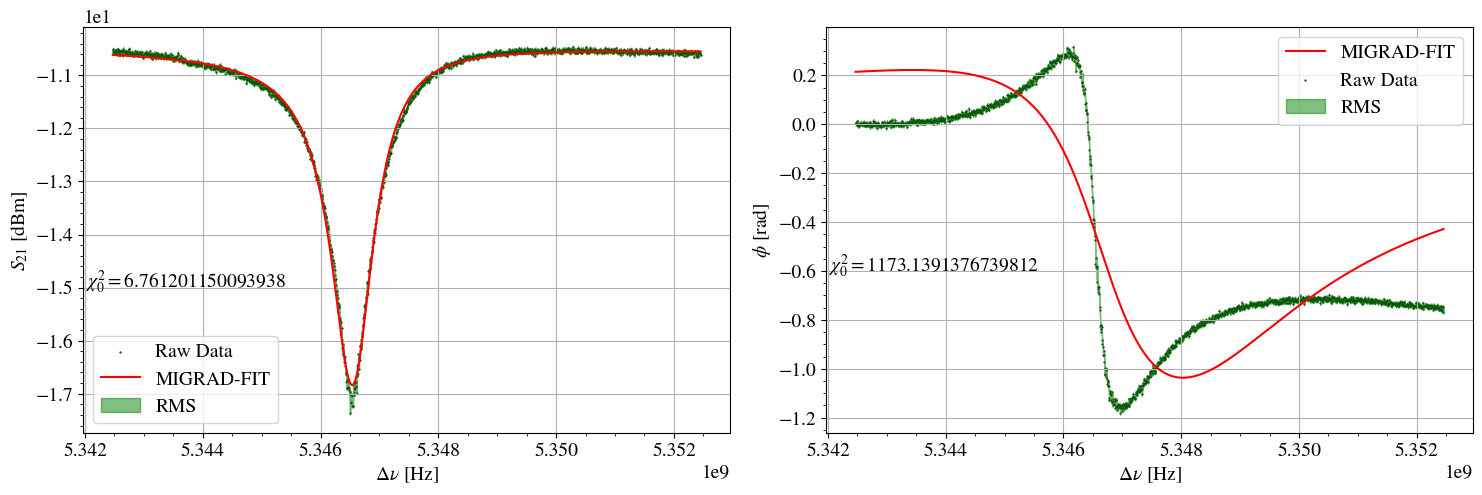

In [377]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs[1].plot(F, phase(F,*mp.values), color='red',label='MIGRAD-FIT')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [dBm]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
fig.tight_layout()
# Optionally add minor ticks and scientific notation
axs[0].legend()
axs[1].legend()
axs[1].minorticks_on()
axs[1].grid()
axs[1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0].minorticks_on()
axs[0].grid()
axs[0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0].text(5.342*1e9,-15,r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof}")
axs[1].text(5.342*1e9,-0.6,r'$\chi^{2}_{0} = $'+f"{mp.fval/mp.ndof}")

Text(5342500000.0, -15, '$\\chi^{2}_{0} = $6.76')

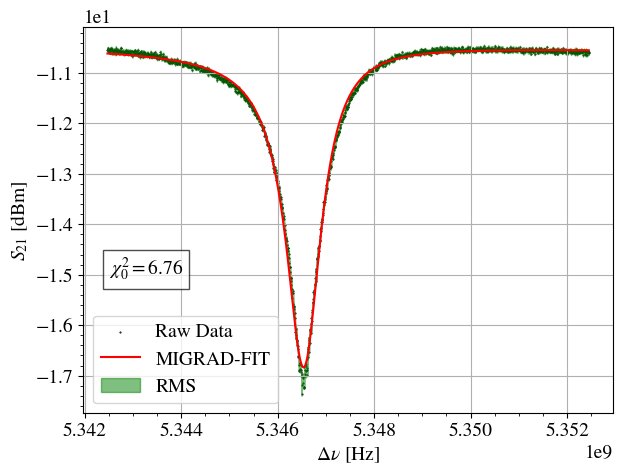

In [380]:
fig, axs = plt.subplots(1,1)
axs.scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs.plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs.set_xlabel(r'$\Delta \nu$ [Hz]')
axs.set_ylabel(r'$S_{21}$ [dBm]')
axs.fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
fig.tight_layout()
# Optionally add minor ticks and scientific notation
axs.legend()
axs.minorticks_on()
axs.grid()
axs.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
text_str = f'FWHM = {FWHM:.0f} Hz\n' + r'$Q = \frac{\nu_{0}}{FWHM}$' + f' = {5.342*1e9/FWHM:.0f}'

# Place the combined text with a bounding box
axs.text(5.3425*1e9,-15,r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}",
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))


In [200]:
print('Q(S21) = ', m.values[3])
print('Q(phase) = ', mp.values[3])
print('Q_c(S21) = ', m.values[4])
print('Q_c(phase) = ', mp.values[4])

Q(S21) =  6846.29759392851
Q(phase) =  2639.2722703523355
Q_c(S21) =  11359.450211464788
Q_c(phase) =  0.6244130293259086


In [201]:
Qi = (m.values[3]**(-1)+m.values[4]**(-1))**(-1)
print('Qi(S21) = ',Qi)

Qi(S21) =  4271.737556864505
